Image shape:  (720, 1280, 3)


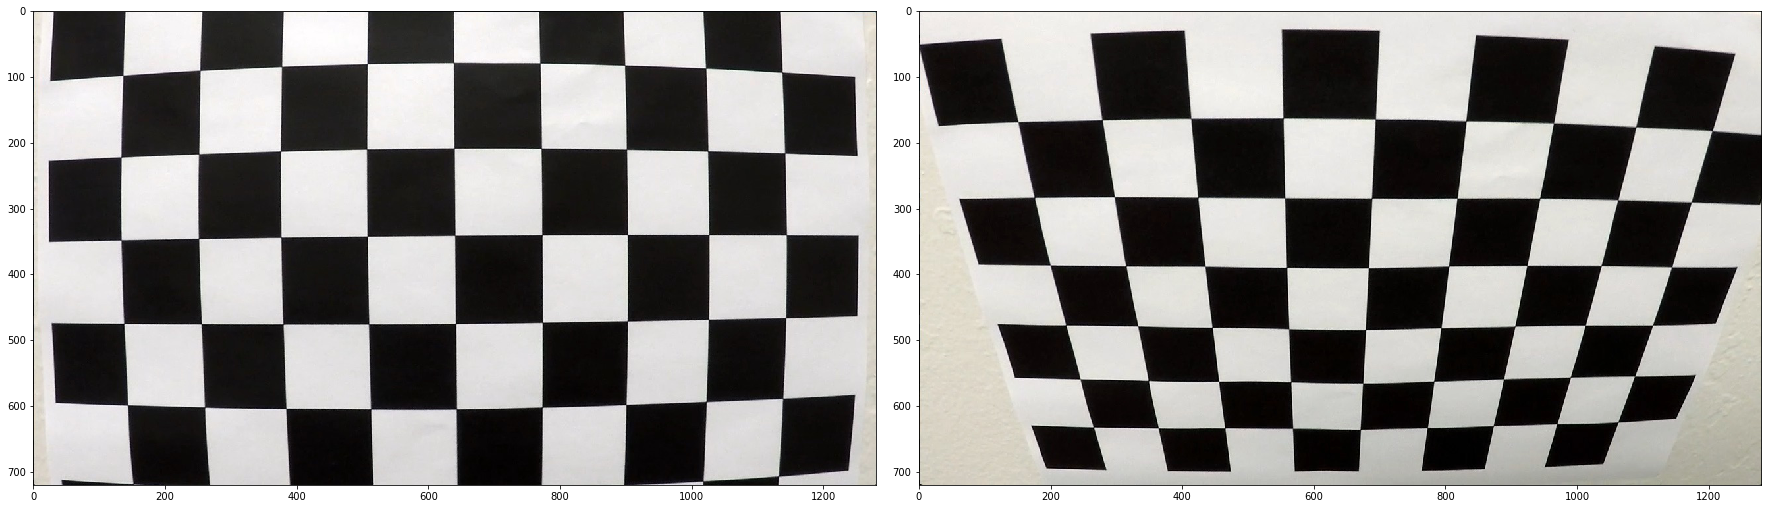

In [38]:
 import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
# %matplotlib qt
###VIEWING CHESSBOARD IMAGES###
image1 = mpimg.imread('./camera_cal/calibration1.jpg')
image2 = mpimg.imread('./camera_cal/calibration2.jpg')
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(image1)
ax2.imshow(image2)
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)
print('Image shape: ',image1.shape)


0
1
2


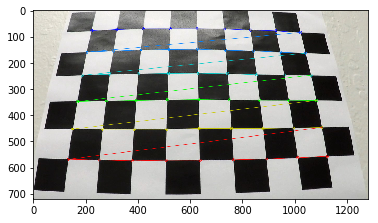

In [39]:
### FINDING IMAGE AND OBJECT POINTS ###
import numpy as np
import glob
import cv2
#Finding object points and image points
numx = 9
numy = 6
objecpts = np.zeros((numx*numy,3), np.float32)
objecpts[:,:2] = np.mgrid[0:numx,0:numy].T.reshape(-1,2)

object_points = []
image_points = []
k=[]
images = glob.glob('./camera_cal/calibration*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    retts, corners = cv2.findChessboardCorners(gray,(numx, numy),None)
    if retts == True:
        
        object_points.append(objecpts)
        image_points.append(corners)
        img = cv2.drawChessboardCorners(img, (numx,numy), corners, retts)
        k.append(img)
for x in range(0, 3):
    print(x)
    plt.imshow(k[x])


In [40]:
#Covert RGB to Gray
def graycvt(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

#Histogram Equalization
def histEq(image):
    yuv_image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
    yuv_image[:,:,0] = cv2.equalizeHist(yuv_image[:,:,0])
    image_out = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB)
    return image_out

#Define Region of Interest in Image. Reference from Udacity's Self Driving Car Nanodegree Project 1 Help Code
def region_of_interest(img, vertex):
    screen = np.zeros_like(img)   
    if len(img.shape) > 2:
        ch_count = img.shape[2]
        ignore_screen_color = (255,) * ch_count
    else:
        ignore_screen_color = 255   
    cv2.fillPoly(screen, vertex, ignore_screen_color)
    screened_image = cv2.bitwise_and(img, screen)
    return screened_image
    
#Convert to gray and Undistort Image
def undistort(image, object_points, image_points):
    gray = graycvt(image)
    retts, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points,image_points,gray.shape[::-1],None,None)
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    return undist

#Derivative Binary Thresholds
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = graycvt(img)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0])&(scaled_sobel <= thresh[1])] = 1
    return grad_binary

#S channel 
def trap(a,thresh):
    b=a[:,:,2]
    c=np.zeros_like(b)
    c[(b > thresh[0])&(b<=thresh[1])] = 1
    return c

def hls_select(image,thresh =(0,255)):
    hls = cv2.cvtColor(histEq(image),cv2.COLOR_RGB2HLS)
    bout=trap(hls,thresh)
    return bout

#V channel
def hsv_select(image,thresh=(0,255)):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    bout=trap(hsv,thresh)
    return bout

#Binary Image
def binary(image):
    undist = undistort(image, object_points, image_points)
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=9, thresh=(30,100))
    combined_binary = np.zeros_like(gradx)
    s_channel = hls_select(undist, thresh=(120,255))
    v_channel = hsv_select(undist, thresh=(75,255))
    combined_binary[(gradx==1)|(s_channel==1) & (v_channel ==1)]=1
    imshape = combined_binary.shape
    vertex = np.array([[(100,imshape[0]),(620,420),(750,450),(1200,imshape[0])]],dtype=np.int32)
    binary_output = region_of_interest(combined_binary,vertex)
    return undist, binary_output

#Perspective Transform and Wraped
def perspectiveTransform(image,src,dst):
    M = cv2.getPerspectiveTransform(src,dst)
    transform_img = cv2.warpPerspective(image,M,(1280,720))
    return transform_img

def curvy(a,b,c,e):
    d=((1+(2*a[0]*b*c + a[1])**2)**1.5)/np.absolute(2*a[0])
    f=((1+(2*e[0]*b*c + e[1])**2)**1.5)/np.absolute(2*e[0])
    g=(d+f)/2
    return g

#Measure curvature radius
def measureCurve(graphy,lx,ly,rx,ry):
    yppx = 30/720
    xppx= 3.7/700
    ymax = np.max(graphy)
    lpoly = np.polyfit(ly*yppx, lx*xppx, 2)
    r_poly = np.polyfit(ry*yppx, rx*xppx,2)
    rad=curvy(lpoly,ymax,yppx,r_poly)
    return rad
def calib(a,b):
    c=a[0]*b**2 + a[1]*b + a[2]
    return c

#Measure offset from car center to lane center
def offcenter(image,graphy,lfit,r_fit):
    ymax = np.max(graphy)
    x_per_pix = 3.7/700
    lx_bottom = calib(lfit,ymax)
    rx_bottom = calib(r_fit,ymax)
    centre_lane= (lx_bottom + rx_bottom)/2
    center_car = image.shape[1]/2
    xx = (centre_lane-center_car)*x_per_pix
    return xx
print("jj")

jj


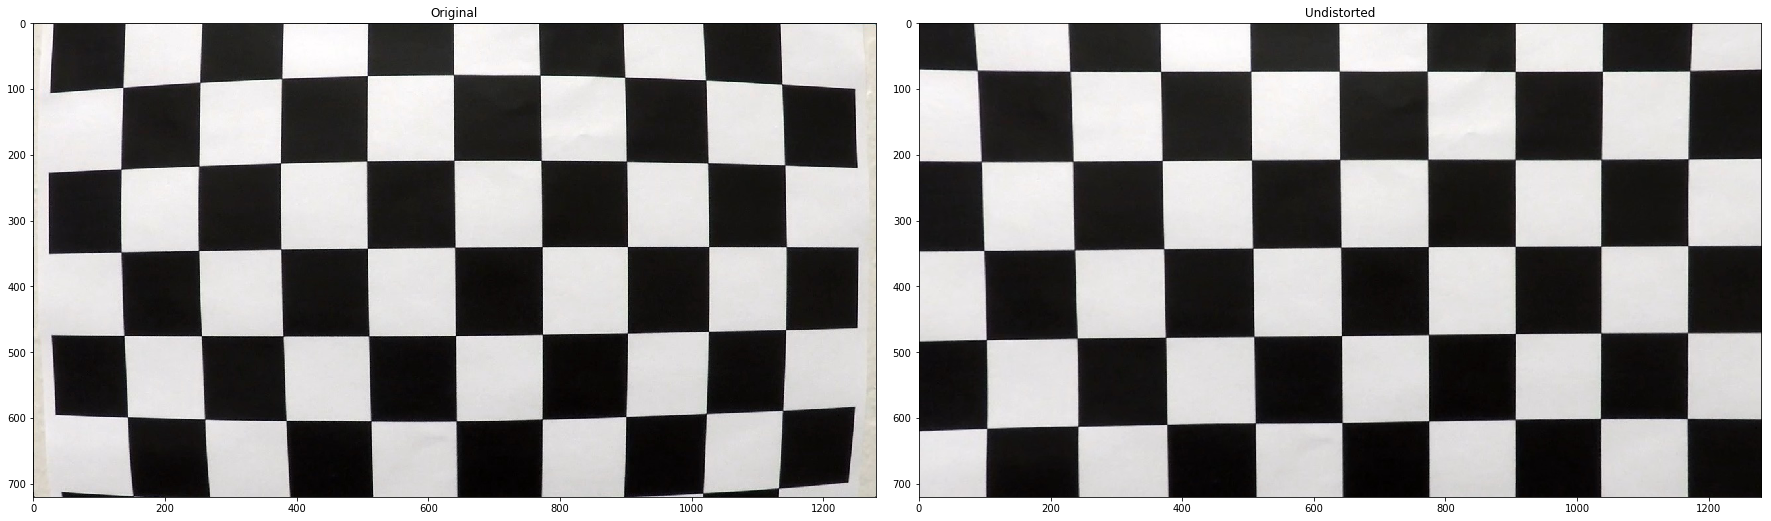

In [41]:
# Distortion correction example
#Undistort the chessboard Image
ca1 = mpimg.imread('./camera_cal/calibration1.jpg')
undistort_ca1 = undistort(ca1, object_points, image_points)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(ca1)
ax1.set_title('Original')
ax2.imshow(undistort_ca1)
ax2.set_title('Undistorted')
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)


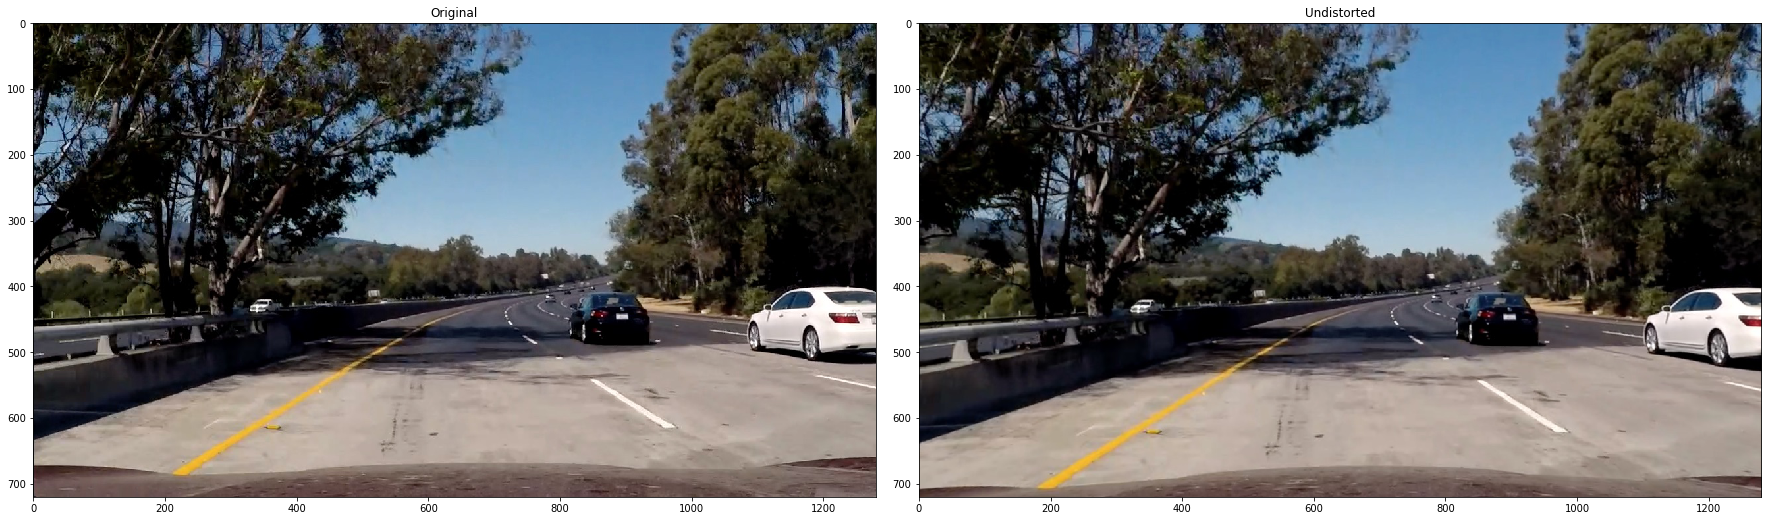

In [42]:
#Undistort a Test Image
%matplotlib inline
ca1 = mpimg.imread('./test_images/test5.jpg')
undistort_ca1 = undistort(ca1, object_points, image_points)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(ca1)
ax1.set_title('Original')
ax2.imshow(undistort_ca1)
ax2.set_title('Undistorted')
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)


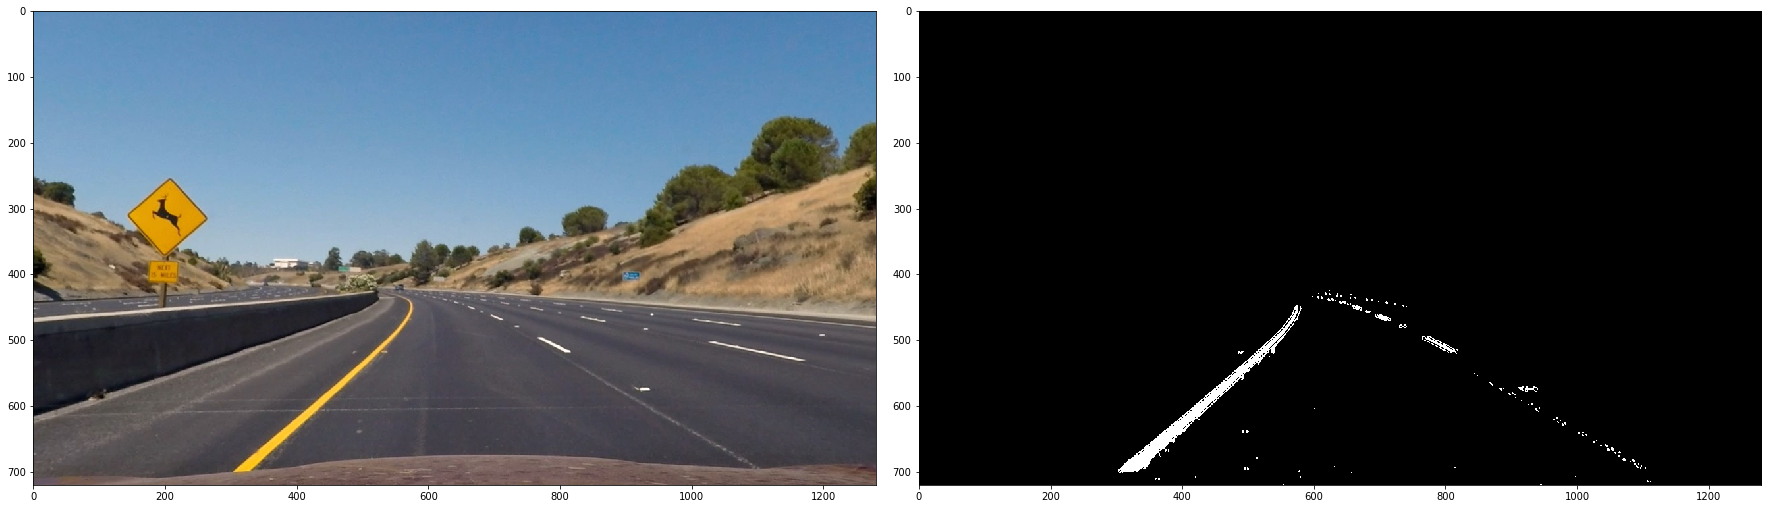

In [43]:
#Sample Binary Image and Screen Image
#%matplotlib qt
img1 = mpimg.imread('./test_images/test2.jpg')
undist, binary_output = binary(img1)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(undist)
ax2.imshow(binary_output,cmap='gray')
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)


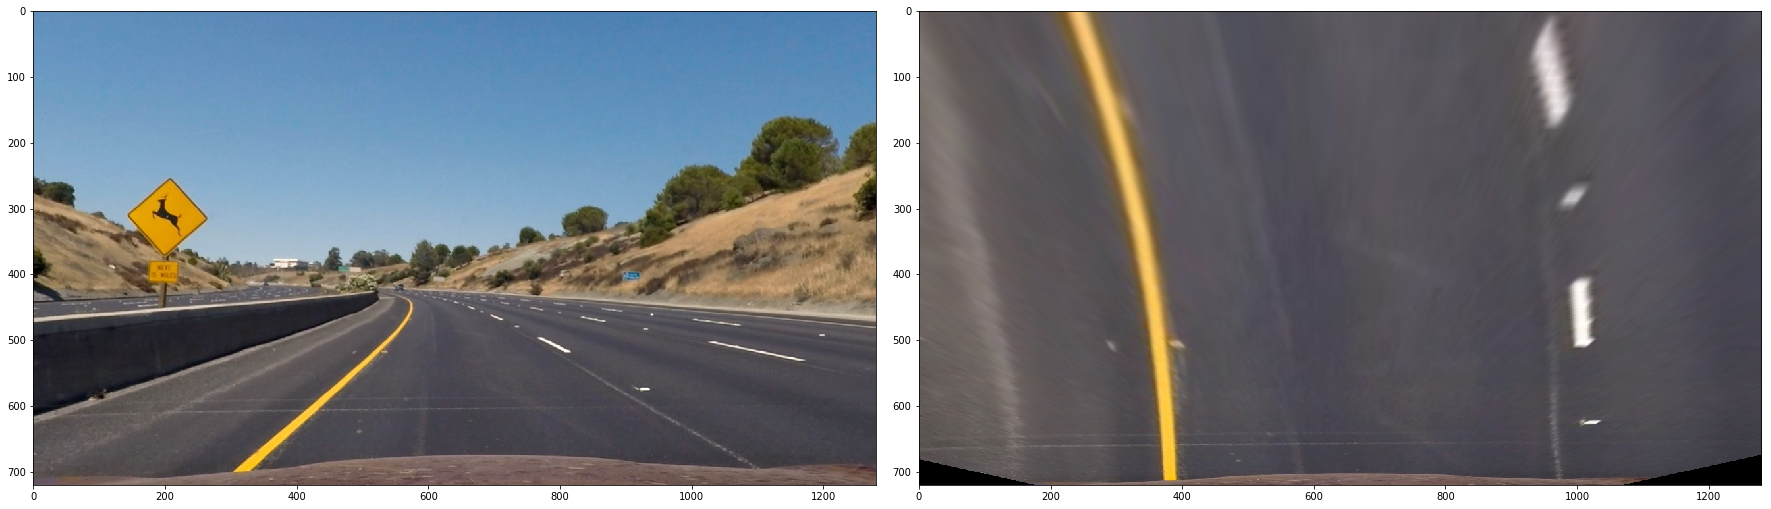

In [44]:
#Sample top dpwn View
src = np.float32([
    [585,460],
    [203,720],
    [1127,720],
    [695,460]])
dst = np.float32([
    [320,0],
    [320,720],
    [960,720],
    [960,0]])

M = cv2.getPerspectiveTransform(src,dst)
undist_warped = cv2.warpPerspective(undist,M,(1280,720))
binary_warped = cv2.warpPerspective(binary_output,M,(1280,720))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(undist)
ax2.imshow(undist_warped)
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)


In [66]:
def process(image):
#     src = np.float32([[556,479],[732,476],[269,683],[1046,683]])
#     dst = np.float32([[320,0],[960,0],[320,683],[960,683]])
#src and dst coordinates are referenced from Udacity's write-up paper
#Many parts of the codes are referenced from Udacity's SDCND lectures.
    src = np.float32([
        [585,460],
        [203,720],
        [1127,720],
        [695,460]])
    dst = np.float32([
        [320,0],
        [320,720],
        [960,720],
        [960,0]])
    undist, binary_output = binary(image)
    binary_warped = perspectiveTransform(binary_output,src,dst)
    nzero = binary_warped.nonzero()
    nzeroy = np.array(nzero[0])
    nzerox = np.array(nzero[1])
    gap = 100
    
    global l_fit, r_fit, l_poly_list, r_poly_list
    if ((l_fit.any()==False) and (r_fit.any()==False)):
    #if ((l_fit == None) and (r_fit== None)):
    #if (l_fit, r_fit) == (None,None):
        histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:],axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        lx_base = np.argmax(histogram[:midpoint])
        rx_base = np.argmax(histogram[midpoint:]) + midpoint

        #sliding window
        nwindows = 9
        window_height = np.int(binary_warped.shape[0]/nwindows)
        lx_current = lx_base
        rx_current = rx_base
        minpix = 50 #min pixel found in each window
        l_lane_inds = []
        r_lane_inds = []

        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - (window*window_height)
            win_xl_low = lx_current - gap
            win_xl_high = lx_current + gap
            win_xr_low = rx_current - gap
            win_xr_high = rx_current + gap 
            good_l_inds = ((nzeroy >= win_y_low) & (nzeroy < win_y_high) & (nzerox >= win_xl_low) 
                          & (nzerox < win_xl_high)).nonzero()[0]
            good_r_inds = ((nzeroy >= win_y_low) & (nzeroy < win_y_high) & (nzerox >= win_xr_low) 
                          & (nzerox < win_xr_high)).nonzero()[0]

            l_lane_inds.append(good_l_inds)
            r_lane_inds.append(good_r_inds)
            if len(good_l_inds) > minpix:
                lx_current = np.int(np.mean(nzerox[good_l_inds]))
            if len(good_r_inds) > minpix:
                rx_current = np.int(np.mean(nzerox[good_r_inds]))

        l_lane_inds = np.concatenate(l_lane_inds)
        r_lane_inds = np.concatenate(r_lane_inds)

        #Pixel position for l and r
        lx = nzerox[l_lane_inds]
        ly = nzeroy[l_lane_inds]
        rx = nzerox[r_lane_inds]
        ry = nzeroy[r_lane_inds]
        #Fit 2nd polynomial
        l_fit = np.polyfit(ly,lx, 2)
        r_fit = np.polyfit(ry,rx,2)
        l_poly_list = np.array([l_fit])
        r_poly_list = np.array([r_fit])
    else:
        l_lane_inds = ((nzerox > (l_fit[0]*(nzeroy**2) + l_fit[1]*nzeroy + l_fit[2] - gap)) &
                         (nzerox < (l_fit[0]*(nzeroy**2) + l_fit[1]*nzeroy + l_fit[2] + gap)))
        r_lane_inds = ((nzerox > (r_fit[0]*(nzeroy**2) + r_fit[1]*nzeroy + r_fit[2] - gap)) &
                         (nzerox < (r_fit[0]*(nzeroy**2) + r_fit[1]*nzeroy + r_fit[2] + gap)))
        #Pixel position for l and r
        lx = nzerox[l_lane_inds]
        ly = nzeroy[l_lane_inds]
        rx = nzerox[r_lane_inds]
        ry = nzeroy[r_lane_inds]
        #Fit 2nd polynomial
        l_fit = np.polyfit(ly,lx, 2)
        r_fit = np.polyfit(ry,rx,2)
        
    #Average poly coefficient up to the last 10 frames
    l_poly_list = np.concatenate((l_poly_list,[l_fit]),axis=0)[-5:]
    r_poly_list = np.concatenate((r_poly_list,[r_fit]),axis=0)[-5:]
    l_fit = np.average(l_poly_list,axis=0)
    r_fit = np.average(r_poly_list,axis=0)
    
    #x & y values for plotting
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[ly, lx] = [255,0,0]
    out_img[ry,rx] = [0,0,255]

    ploty = np.linspace(0, binary_warped.shape[0]-1,binary_warped.shape[0])
    l_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    r_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    l_poly = np.array([np.transpose(np.vstack([l_fitx,ploty]))])
    r_poly = np.array([np.flipud(np.transpose(np.vstack([r_fitx,ploty])))])
    lane_poly = np.hstack((l_poly,r_poly))

    window_img = np.zeros_like(out_img)
    cv2.polylines(window_img,np.int32(l_poly),1,(255,0,0),50)
    cv2.polylines(window_img,np.int32(r_poly),1,(255,0,0),50)
    result = cv2.fillPoly(window_img,np.int_([lane_poly]),(0,255,0))


    un_warped = perspectiveTransform(result,dst,src)
    undist_copy = np.copy(undist)
    final = cv2.addWeighted(undist_copy,1,un_warped,0.5,0)
    
    #Curvature
    radius = measureCurve(ploty,lx,ly,rx,ry)
    off_center = offcenter(final,ploty,l_fit,r_fit)
    cv2.putText(final,'Radius of Curvature: %.3f (m)' % radius,(20,40),cv2.FONT_HERSHEY_SIMPLEX,
                               1,(0,0,255),1,cv2.LINE_AA)
    cv2.putText(final,'Vehicle is %.3f (m) to the l of the center' % off_center,(20,80),cv2.FONT_HERSHEY_SIMPLEX,
                               1,(0,255,255),3,cv2.LINE_AA)
    return final


print("jj")

jj


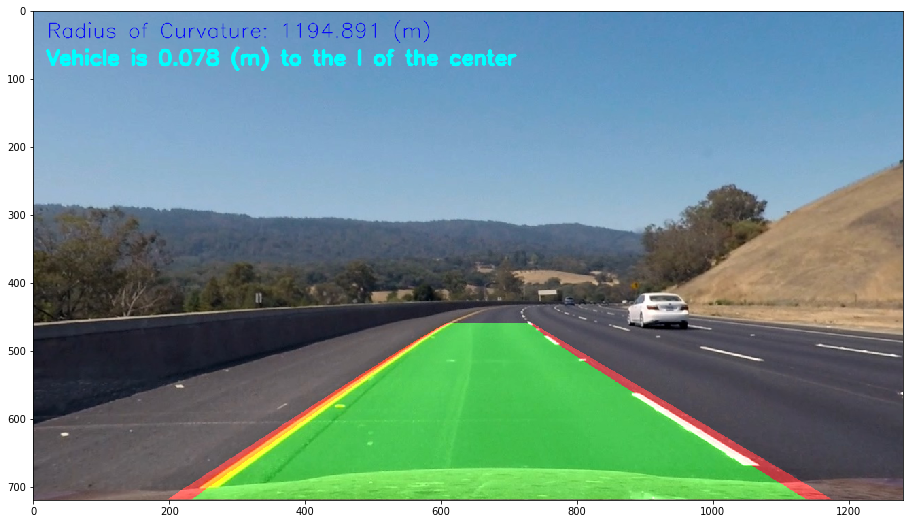

In [68]:
img = mpimg.imread('./test_images/test3.jpg')
#lfit=[]
#rfit=[]
#l_fit, r_fit =None, None
l_fit=np.array([])
r_fit=np.array([])
i = process(img)
#Plot Images


plt.figure(figsize=(24,9))
plt.imshow(i)

In [69]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project_vid5.mp4'
clip1 = VideoFileClip('project_video.mp4')
l_fit=np.array([])
r_fit=np.array([])
#l_fit, r_fit =None, None
project_clip = clip1.fl_image(process)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_vid5.mp4
[MoviePy] Writing video project_vid5.mp4



100%|█████████▉| 1260/1261 [14:31<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_vid5.mp4 

CPU times: user 15min 14s, sys: 31.8 s, total: 15min 45s
Wall time: 14min 32s
